In [51]:
import numpy as np
import pandas as pd
from pylab import plt
from math import sqrt
import time
import datetime
import datetime as dt
import pandas_datareader as web
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import talib
from talib.abstract import *
from datetime import date, timedelta
import itertools
#pip install pandas-datareader for getData to work

#How this program works is that it finds the turning points of the moving average, then using those points, find the actual local max and local min
#Then labeling a 1 if its a local max and -1 for local min, and linearly label all the points in between

In [2]:
def getData(id):
    end = dt.datetime.now()
    start = dt.datetime(2021,1,10)
    data = web.DataReader(id+"-USD", 'yahoo', start, end)
    data = data.rename(columns={"Open":"open","High":"high","Low":"low","Close":"close","Volume":"volume"})
    return data

In [52]:
#this finds the turning point of the moving average 
def minMax(data):
    #this could be EMA or MA 
    data["MA"] = EMA(data["close"],timeperiod=20)
    localMin = []
    localMax = []

    for i in range(len(data)-1):
        if data["MA"].iloc[i] > data["MA"].iloc[i+1] and data["MA"].iloc[i] > data["MA"].iloc[i-1] :
            localMax.append((data["MA"].iloc[i],i))
        elif data["MA"].iloc[i] < data["MA"].iloc[i+1] and data["MA"].iloc[i] < data["MA"].iloc[i-1] :
            localMin.append((data["MA"].iloc[i],i))
        else:
            continue
    localMin = pd.DataFrame(localMin,columns=["localMin","minIndex"] )
    localMax= pd.DataFrame(localMax,columns=["localMax","maxIndex"] )
   
    
    frames = [localMin,localMax]
    minMax = pd.concat(frames, axis=1)

    return minMax

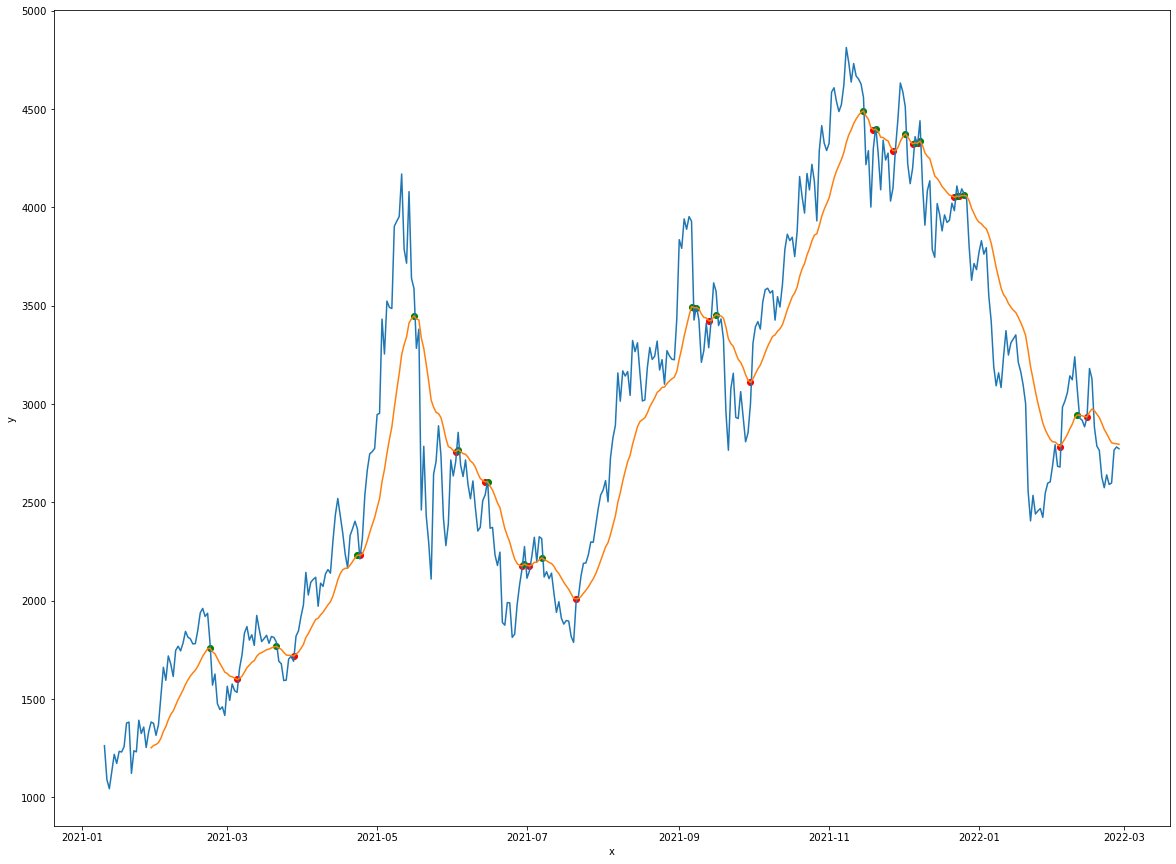

In [53]:
#plot the moving average turning points
plt.figure(figsize=(20, 15))
ax = plt.axes()

ax.plot(eth.index, eth["close"])
#make sure that below is the same timeperiod and MA type as the function minMax
ax.plot(eth.index,EMA(eth["close"],timeperiod=20))
ax.scatter(eth.index[minMax(eth)["minIndex"][:-1].astype(int)],minMax(eth)["localMin"][:-1],color = 'red')
ax.scatter(eth.index[minMax(eth)["maxIndex"][:-1].astype(int)],minMax(eth)["localMax"][:-1],color = 'green')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [54]:
#this function takes in the MA turning points and finds the actual min max on the price chart

def turningPoints(minMax,data):
    isna = False
    if minMax.isna().any().any():
        isna = True
        minMax = minMax.fillna(len(data))
    
    result= []
    minI = int(minMax["minIndex"].iloc[0])
    maxI = int(minMax["maxIndex"].iloc[0])
    
    if minMax["maxIndex"].iloc[0]>minMax["minIndex"].iloc[0]:
        peaki = max(data["close"][minI:maxI])
        prevMinI = minI
        prevMaxI = maxI
        peakIndex = int(np.where(data["close"]== peaki)[0])
        result.append((peaki,data.index[peakIndex],"peak"))
    else:
        troughi = min(data["close"].iloc[maxI:minI])
        prevMinI = minI
        prevMaxI = maxI
        troughIndex = int(np.where(data["close"]== troughi)[0])
        result.append((troughi,data.index[troughIndex],"trough"))
        
    for i in range(1,len(minMax)):
        minI = int(minMax["minIndex"].iloc[i])
        maxI = int(minMax["maxIndex"].iloc[i])
        
        if minMax["maxIndex"].iloc[0]>minMax["minIndex"].iloc[0]:
            
            peaki = max(data["close"][minI:maxI])
            troughi = min(data["close"].iloc[prevMaxI: minI])
            peakIndex = int(np.where(data["close"]== peaki)[0])
            troughIndex = int(np.where(data["close"]== troughi)[0])
            result.append((troughi,data.index[troughIndex],"trough"))
            result.append((peaki,data.index[peakIndex],"peak"))
            
        
        else:

            troughi = min(data["close"].iloc[maxI:minI])
            peaki = max(data["close"].iloc[prevMinI: maxI])
            peakIndex = int(np.where(data["close"]== peaki)[0])
            troughIndex = int(np.where(data["close"]== troughi)[0])
            result.append((peaki,data.index[peakIndex],"peak"))
            result.append((troughi,data.index[troughIndex],"trough"))
        prevMinI = minI
        prevMaxI = maxI
    
    result = pd.DataFrame(result, columns = ["price","date","type"])
    
    #this removes the label, since it will assume automaticlly to be a local min or local max
    if isna:
        result.drop(result.tail(1).index,inplace=True)

    return result

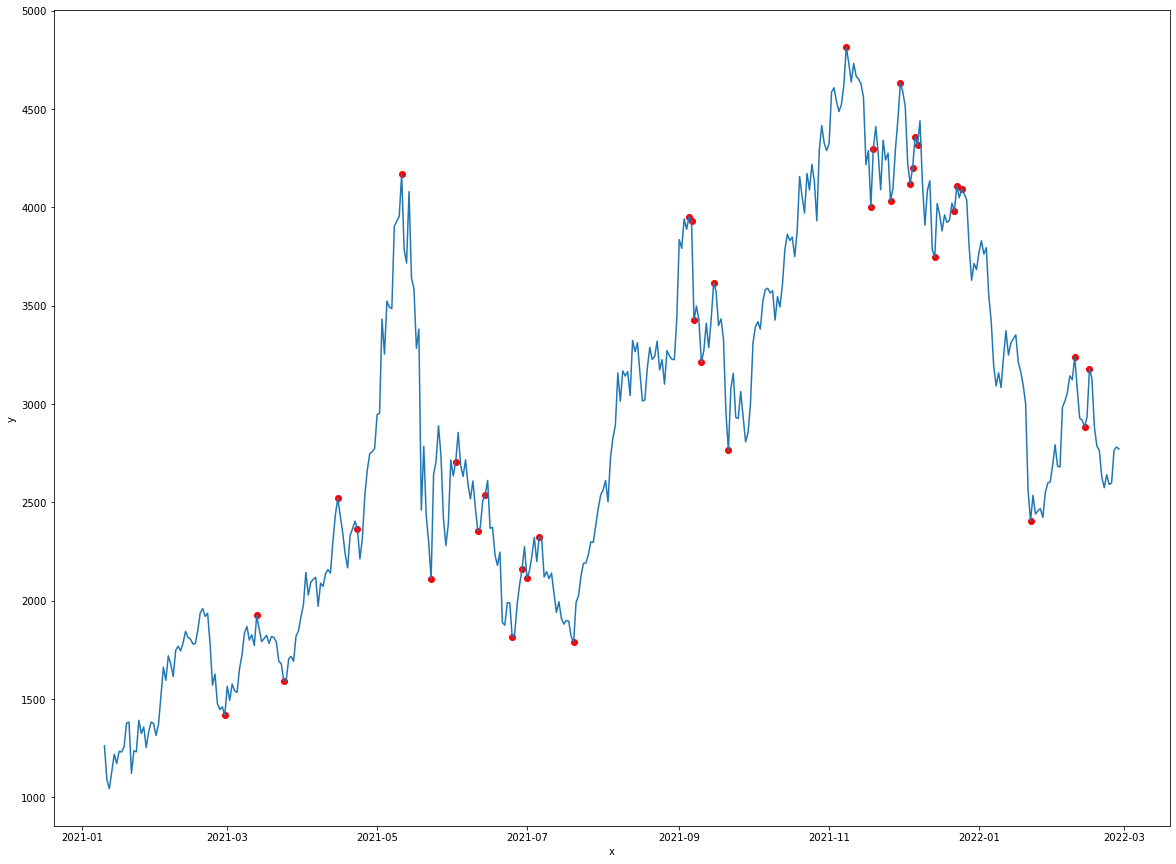

In [55]:
#the plot of the local min and max
eth = getData("eth")
test = turningPoints(minMax(eth),eth)
plt.figure(figsize=(20, 15))
ax = plt.axes()

ax.plot(eth.index, eth["close"])


ax.scatter(test["date"],test["price"],color = 'red')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [49]:
#helper function to label 
def helper(start_date,end_date):
    delta =  end_date[1] - start_date[1]    # returns timedelta
    label = []
    for i in range(int(delta.days + 1)):
        day = start_date[1] + timedelta(days=i)
        if (start_date[2]== "peak"):
            score = np.linspace(1,-1,delta.days+1)
        else:
            score = np.linspace(-1,1,delta.days+1)
        label.append((day,score[i]))
    return label

In [43]:
def labeling(TurnPdata):
    label = []
    prev = TurnPdata.iloc[0]
    for i in range(1,len(TurnPdata)):
        now = TurnPdata.iloc[i]
        label.append(helper(prev,now))
        prev = now
    return pd.DataFrame(list(itertools.chain.from_iterable(label)),columns =["Dates","Label"]).drop_duplicates(subset=["Dates"])

In [44]:
labeling(test)

,Dates,Label
0,2021-02-28,-1.000000
1,2021-03-01,-0.846154
2,2021-03-02,-0.692308
3,2021-03-03,-0.538462
4,2021-03-04,-0.384615
...,...,...
383,2022-02-11,0.000000
384,2022-02-12,-0.500000
385,2022-02-13,-1.000000
387,2022-02-14,0.000000


In [50]:
test

,price,date,type
0,1416.048950,2021-02-28,trough
1,1924.685425,2021-03-13,peak
2,1593.413452,2021-03-24,trough
3,2519.116211,2021-04-15,peak
4,2363.586182,2021-04-23,trough
5,4168.701172,2021-05-11,peak
6,2109.579834,2021-05-23,trough
7,2706.125000,2021-06-02,peak
8,2353.768799,2021-06-11,trough
9,2537.891113,2021-06-14,peak
